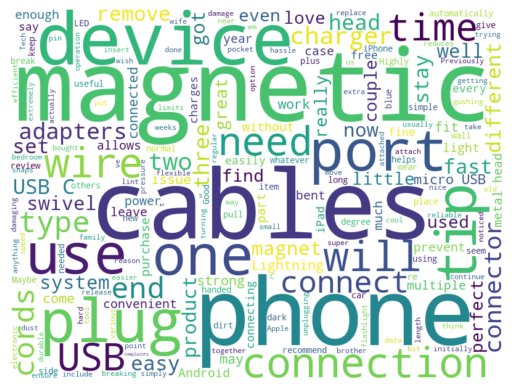

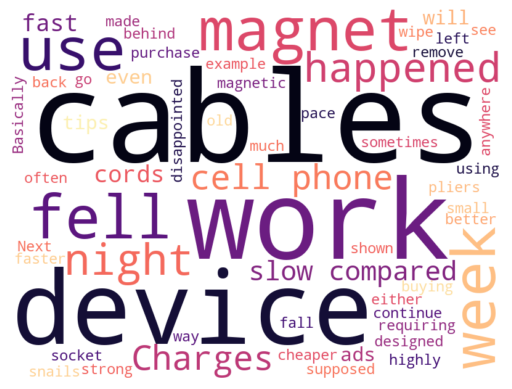

In [2]:
from collections import Counter
import wordcloud
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator    
import plotly.express as px

df = pd.read_json("../reviews_both.json")

# Extract 'location' and 'date' from 'location_and_date'
df['location'] = df['location_and_date'].str.extract('Reviewed in (\D+)')
df['date'] = df['location_and_date'].str.extract('on (\w+ \d+, \d+)')
df['date'] = pd.to_datetime(df['date'])


# Impute positive or negative based on the 'rating' column
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')


magnetic_charger = df[df["asin"] == "B0BPR6FL7M"]
ab_charger = df[df["asin"] == "B01GGKYKQM"]



# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["charge", "charging", "cable", "cord"])
# Start with one review:

positive_reviews = magnetic_charger[magnetic_charger["rating"] >3]

positive_reviews_text = " ".join(review for review in positive_reviews["text"])


# Create and generate a word cloud image:
pos_wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=600).generate(positive_reviews_text)

# Display the generated image:
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

neg_reviews = magnetic_charger[magnetic_charger["rating"] < 3]

neg_reviews_text = " ".join(review for review in neg_reviews["text"])


# Create and generate a word cloud image:
neg_wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=600, colormap="magma").generate(neg_reviews_text)

# Display the generated image:
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## save wordclouds
neg_wordcloud.to_file('assets/negative_word_cloud.png')
pos_wordcloud.to_file('assets/positive_word_cloud.png')


In [3]:

# Define the time intervals for binning
bins = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='M')

# Bin the dates into specific time intervals
df['date_bin'] = pd.cut(df['date'], bins=bins, labels=bins[:-1])

# Group the data by 'date_bin' and 'rating' and count the occurrences
grouped = df.groupby(['date_bin', 'rating']).size().unstack(fill_value=0)

# Reset index and convert the date_bin column back to datetime
grouped = grouped.reset_index()
grouped['date_bin'] = pd.to_datetime(grouped['date_bin'])

# Plot the data using Plotly
fig = px.line(grouped, x='date_bin', y=[1, 2, 3, 4, 5],
              labels={'value': 'Count', 'date_bin': 'Date Bin'},
              title='Number of Ratings by Date Bin')
fig.show()

## Pipeline to clean text data for sentiment analysis

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')





[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\berni\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\berni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\berni\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from nltk.corpus import stopwords

# Define the preprocessing functions
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back to a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


# Define the pipeline
pipeline = Pipeline([
    ('preprocess', CountVectorizer(preprocessor=preprocess_text)),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear'))
])

# Separate the features (preprocessed text) and target variable (sentiment)
X = magnetic_charger['text']
y = magnetic_charger['sentiment']

# Train the pipeline
pipeline.fit(X, y)

# Get the feature names from the CountVectorizer
feature_names = pipeline.named_steps['preprocess'].get_feature_names_out()

# Get the coefficients from the trained LogisticRegression classifier
coefficients = pipeline.named_steps['classifier'].coef_[0]

# Create a DataFrame with feature names and their corresponding coefficients
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Sort the DataFrame by the absolute value of coefficients
sorted_coef_df = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)


# Select the top 15 words with coefficients
top_15_words_with_coefs = sorted_coef_df.head(15)

top_15_words_with_coefs.to_csv("important_words.csv")

# Create a color mapping function
def get_color(coeff):
    if coeff > 0:
        intensity = int(coeff * 255)  # Increase intensity for positive coefficients

        if intensity > 200:
            intensity = 200
        if intensity < 50:
            intensity = 50
        return f"rgb(0, {intensity}, 0)"  # Green background for positive coefficients
    else:
        intensity = int(abs(coeff) * 255)  # Increase intensity for negative coefficients
        if intensity > 200:
            intensity = 200
        if intensity < 50:
            intensity = 50
        return f"rgb({intensity}, 0, 0)"  # Red background for negative coefficients

# Create HTML table with colored background
html_table = "<table><tr><th>Word</th><th>Coefficient</th></tr>"
for _, row in sorted_coef_df.head(15).iterrows():
    word = row['feature']
    coefficient = row['coefficient']
    color = get_color(coefficient)
    html_table += f"<tr><td style='background-color:{color}'>{word}</td><td>{coefficient:.4f}</td></tr>"
html_table += "</table>"

# Display the HTML table
from IPython.display import display, HTML
display(HTML(html_table))

Word,Coefficient
great,5.2171
different,-4.3647
good,4.1057
needed,3.9799
perfect,3.3741
slow,-3.1131
well,2.6013
take,-2.5504
plugged,-2.4146
week,-2.3475


In [42]:

# Filter negative reviews
negative_reviews = ab_charger[ab_charger['rating'] < 3]


# Filter negative reviews
negative_reviews = df[df['rating'] < 3]

# Preprocess text and count occurrences of "weak" on a monthly basis
weak_counts = []
dates = []
stop_words = set(stopwords.words('english'))
for date in pd.to_datetime(negative_reviews['date']):
    # Extract year and month
    year = str(date.year)
    month = str(date.month).zfill(2)  # Zero-padding for single-digit months
    
    # Filter by year and month
    filtered_reviews = negative_reviews[
        (pd.to_datetime(negative_reviews['date']).dt.year == date.year) &
        (pd.to_datetime(negative_reviews['date']).dt.month == date.month)
    ]
    
    # Count occurrences of "weak"
    weak_count = 0
    for review in filtered_reviews['text']:
        # Convert to lowercase
        review = review.lower()
        
        # Tokenize the review
        tokens = word_tokenize(review)
        
        # Remove stopwords
        tokens = [token for token in tokens if token not in stop_words]
        
        # Count occurrences of "weak"
        weak_count += tokens.count('weak')
    
    weak_counts.append(weak_count)
    dates.append(pd.to_datetime(f'{year}-{month}'))

# Create a DataFrame with the dates and corresponding weak counts
data = pd.DataFrame({'Date': dates, 'Weak Count': weak_counts})

# Group by month and calculate the sum of weak counts
monthly_counts = data.groupby(pd.Grouper(key='Date', freq='M')).sum().reset_index()

# Fill missing months with 0's
min_date = monthly_counts['Date'].min()
max_date = monthly_counts['Date'].max()
date_range = pd.date_range(min_date, max_date, freq='MS')
monthly_counts = monthly_counts.set_index('Date').reindex(date_range).fillna(0).reset_index()

# Plot the monthly counts of "weak" occurrences
fig = px.line(monthly_counts, x='index', y='Weak Count', title='Monthly Counts of "weak" in Negative Reviews')
fig.update_layout(xaxis_tickangle=-45)
fig.show()